In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import missingno as msno
import warnings


from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)


In [3]:
train = pd.read_csv('../Data/train_data_cleaned.csv')
test = pd.read_csv('../Data/test_data.csv')

In [56]:
train[['C-2 Date', 'C-3 Date','Assembly Date','Accident Date']] = train[['C-2 Date', 'C-3 Date','Assembly Date','Accident Date']].apply(pd.to_datetime)

In [20]:
y = train['Claim Injury Type']
x = train.drop(columns= 'Claim Injury Type')


In [21]:
x.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'County of Injury', 'COVID-19 Indicator', 'District Name',
       'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code',
       'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
       'Number of Dependents'],
      dtype='object')

<br>

## 4. Model Selection

Hold out method

In this approach we randomly split the complete data into training and test sets. Then we perform the model training on the training set and use the validation set for validation purpose. 80% of the data will be used for training purposes, while 20% for validation.

In [22]:
train_set, val_set, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    shuffle=True, 
                                                    stratify=y
                                                   )

<br>

##### 4.1 Addressing the inconsistencies found

##### 4.1.1 `Accident Date`

In order to have the different components of the date (year, month and day), we are going to split the column `Accident Date` into three columns. We then proceed to remove the column from the datasets.

In [23]:
train_set['Accident Year'] = train_set['Accident Date'].apply(lambda x: x.year)
val_set['Accident Year'] = val_set['Accident Date'].apply(lambda x: x.year)
test['Accident Year'] = train_set['Accident Date'].apply(lambda x: x.year)

In [24]:
train_set = train_set.drop(columns = 'Accident Date')
val_set = val_set.drop(columns = 'Accident Date')
test = test.drop(columns = 'Accident Date')

One aspect that is important to check is if the age at injury aligns with the difference between the accident date and the birth year. We had already seen that the feature `Age at Injury` has inconsistent values, therefore this mismatch might occur.

In [25]:
train_set.apply(lambda row: row['Accident Year'] - row['Birth Year'] == row['Age at Injury'], axis=1).value_counts()

False    240703
True     218517
Name: count, dtype: int64

From the output above, we can see that in 21 8517 claims, there is a misalignment between the calculated age and the recorded age at the time of injury.

In [26]:
(train_set['Accident Year'] - train_set['Birth Year'] - train_set['Age at Injury']).value_counts()

 0.0      218517
 1.0      194511
-1.0         241
 119.0        67
 118.0         6
 120.0         2
Name: count, dtype: int64

The output above illustrates the differences in ages calculated from the `Accident Year`, `Birth Year`, and `Age at Injury`. Most differences are minor, with the majority falling within a 1-year difference. However, there are also significant anomalies where some records show a difference of more than 100 years. Also, there is some values that cannot be calculated due to missing values in some of these columns.

Given the inconsistencies and missing values in the date related data, these issues will be addressed. Since, some rows have mismatch between the calculated age and the recorded age at the time of injury we update the age based on the accident year and birth year

In [27]:
train_set[train_set['Birth Year'].isna() & train_set['Accident Year'].notna() & train_set['Age at Injury'].notna()].head()

,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Number of Dependents,Accident Year
437511,31.0,N,2022-05-02,N,3.063832,NaN,2022-04-30,NaT,HEALTH & HOSPITAL CORP.,3A. SELF PUBLIC,BRONX,N,NYC,2023-01-09,F,0.0,62.0,IV,99.0,1.0,-9.0,10451,2.0,2022.0
71069,31.0,N,2020-05-29,N,0.000000,NaN,2020-06-08,2020-05-20,STARR SPECIALTY INSURANCE,1A. PRIVATE,SUFFOLK,N,HAUPPAUGE,NaN,M,0.0,54.0,UK,45.0,52.0,34.0,34482,6.0,2019.0
56317,33.0,N,2020-04-21,Y,3.213783,NaN,2020-05-21,2020-04-08,"POLICE, FIRE, SANITATION",3A. SELF PUBLIC,RICHMOND,N,NYC,2021-09-27,M,1.0,92.0,IV,27.0,10.0,31.0,10308,6.0,2020.0
164387,25.0,N,2020-12-10,Y,3.132935,NaN,2020-12-18,2020-11-03,FEDERAL INSURANCE COMPANY,1A. PRIVATE,ERIE,N,BUFFALO,2021-03-09,M,1.0,71.0,UK,98.0,80.0,90.0,02370,6.0,2019.0
47412,59.0,N,2020-03-24,N,0.000000,NaN,2020-03-24,NaT,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,WESTCHESTER,N,NYC,NaN,M,0.0,23.0,III,53.0,59.0,33.0,10587,3.0,2018.0


There are some rows, that eventhough there are no values in the feature `Birth Year`, we can find based on the values in `Age at Injury` and `Accident Year`.

In [28]:
train_set.loc[train_set['Birth Year'].isna() & train_set['Accident Year'].notna() & train_set['Age at Injury'].notna(), 'Birth Year'] = (
    train_set['Accident Year'] - train_set['Age at Injury'])

In [29]:
val_set.loc[val_set['Birth Year'].isna() & val_set['Accident Year'].notna() & val_set['Age at Injury'].notna(), 'Birth Year'] = (
    val_set['Accident Year'] - val_set['Age at Injury'])

Some rows have the same year in `Accident Year` and `Birth Year` and that is inconsistent. Based on that, the values in `Birth Year` will be replaced as missing.

In [30]:
train_set[train_set["Birth Year"] == train_set["Accident Year"]].head(5)

,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Number of Dependents,Accident Year
245374,0.0,N,2021-05-14,N,0.0,2021.0,NaT,NaT,AMERICAN GUAR & LIAB INS CO,1A. PRIVATE,CHENANGO,N,BINGHAMTON,NaN,F,0.0,NaN,I,0.0,0.0,0.0,13815,5.0,2021.0
137963,0.0,N,2020-10-15,N,0.0,2020.0,2020-08-14,NaT,"GENERAL MOTORS, LLC",4A. SELF PRIVATE,NIAGARA,N,BUFFALO,NaN,F,0.0,NaN,I,99.0,59.0,38.0,NaN,5.0,2020.0
66395,0.0,N,2020-05-15,N,NaN,2020.0,NaT,NaT,STATE INSURANCE FUND,2A. SIF,DUTCHESS,N,ALBANY,NaN,F,0.0,61.0,II,0.0,0.0,0.0,12601,1.0,2020.0
235023,0.0,N,2021-04-27,N,0.0,2021.0,2021-04-23,NaT,GREAT NECK UNION FREE,3A. SELF PUBLIC,NASSAU,N,NYC,NaN,F,0.0,NaN,IV,74.0,10.0,17.0,11021,5.0,2021.0
127357,0.0,N,2020-09-23,Y,0.0,2020.0,NaT,2020-08-20,STATE INSURANCE FUND,2A. SIF,NEW YORK,N,NYC,NaN,F,0.0,62.0,IV,0.0,0.0,0.0,11356,2.0,2020.0


In [31]:
train_set.loc[train_set["Birth Year"] == train_set["Accident Year"], "Birth Year"] = np.nan

In [32]:
val_set.loc[val_set["Birth Year"] == val_set["Accident Year"], "Birth Year"] = np.nan

Since, some rows have the age at injury different from the difference between the birth year and the year of the accident, those will be updated.

In [33]:
train_set['Age at Injury'] = train_set['Accident Year'] - train_set['Birth Year']

In [34]:
val_set['Age at Injury'] = val_set['Accident Year'] - val_set['Birth Year']

In [35]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
import numpy as np

output_notebook()

cleaned_age = train_set['Age at Injury'].dropna()

hist, edges = np.histogram(cleaned_age, bins=40)

p = figure(title='Histogram of Age at Injury')

p.quad(
    top=hist,
    bottom=0,
    left=edges[:-1],
    right=edges[1:],
    fill_color='#FF8C00',
    line_color='black',      
    line_width=1 
)

# Display the plot in the notebook
show(p)

Loading BokehJS ...

<br>

#### 4.1.2. `Zip Code`

As previously mentioned, there were some Zip codes that were inconsistent, therefore we will address them.

In [36]:
len(train_set["Zip Code"].unique())

9135

In [37]:
len(train_set[train_set["Zip Code"] == '10567'])

406

In [38]:
len(train_set[train_set["Zip Code"] == 10567.0])

0

The `fix_zip_code` function standardizes zip codes by converting any float values to integers and then back to strings. This ensures consistent formatting across all zip code entries.

In [39]:
def fix_zip_code(x):
    if isinstance(x, float) and x.is_integer():
        return int(str(int(x))[:5])
    if isinstance(x, str) and x.isnumeric():
        return int(str(int(x))[:5])
    if isinstance(x, str) and (not x.isnumeric()):
        return (np.nan)
    if x != x:
        return np.nan
    try:
        return((int(str(int(x))[:5])))
    except:
        warnings.warn(f"{x} cannot be turned into a integer of 5 numbers", UserWarning)
        return np.nan

In [40]:
train_set['Zip Code'] = train_set['Zip Code'].apply(fix_zip_code)
val_set['Zip Code'] = val_set['Zip Code'].apply(fix_zip_code)
test['Zip Code'] = test['Zip Code'].apply(fix_zip_code)

In [41]:
val_set['Zip Code'].dtype 

dtype('float64')

In [42]:
type(np.nan)

float

Checking if it worked.

In [43]:
len(train_set["Zip Code"].unique())

7304

In [44]:
len(train_set[train_set["Zip Code"] == '10567'])

0

In [45]:
len(train_set[train_set["Zip Code"] == 10567.0])

406

Now, the values for the `Zip Code` feature are standardized.

<br>

##### 4.2 Feature engineering

###### 4.2.1 Dummy Features

In [46]:
dummy_cols = []

To create binary indicators for whether each form was received, we'll define new columns: `Received_Employer_report` and `Received_employee_claim`. Each will be set to 1 if the corresponding date is present, and 0 if it's missing (already replaced with 0).

In [47]:
train_set["Received_C-2"] = train_set["C-2 Date"].apply(lambda x: 1 if x != 0 else 0)
val_set["Received_C-2"] = val_set["C-2 Date"].apply(lambda x: 1 if x != 0 else 0)
test["Received_C-2"] = test["C-2 Date"].apply(lambda x: 1 if x != 0 else 0)
dummy_cols.append("Received_C-2")

In [48]:
train_set["Received_C-3"] = train_set["C-3 Date"].apply(lambda x: 1 if x != 0 else 0)
val_set["Received_C-3"] = val_set["C-3 Date"].apply(lambda x: 1 if x != 0 else 0)
test["Received_C-3"] = test["C-3 Date"].apply(lambda x: 1 if x != 0 else 0)
dummy_cols.append("Received_C-3")

The same will be applied to indicate if a hearing was held. We'll create a new column, `Hearing_held`, set to 1 if the `First Hearing Date` happened and 0 if did not (already replaced with 0).

In [49]:
train_set["Hearing_held"] = train_set["First Hearing Date"].apply(lambda x: 1 if x != 0 else 0)
val_set["Hearing_held"] = val_set["First Hearing Date"].apply(lambda x: 1 if x != 0 else 0)
test["Hearing_held"] = test["First Hearing Date"].apply(lambda x: 1 if x != 0 else 0)
dummy_cols.append("Hearing_held")

There are also some features that are binary categorical variables, like yes (Y) and no (N), we will convert it to 0 and 1. One of them will be discarded.

In [50]:
train_set = pd.get_dummies(train_set, columns=['Attorney/Representative', 'COVID-19 Indicator'], drop_first=True, dtype=int)
val_set = pd.get_dummies(val_set, columns=['Attorney/Representative', 'COVID-19 Indicator'], drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=['Attorney/Representative', 'COVID-19 Indicator'], drop_first=True, dtype=int)

###### 4.2.3 Date splitting

In [51]:
train_set['C-2 Year'] = train_set['C-2 Date'].apply(lambda x: x.year - 1970 if pd.notnull(x) else None)
train_set['C-2 Month'] = train_set['C-2 Date'].apply(lambda x: x.month if pd.notnull(x) else None)

train_set['C-3 Year'] = train_set['C-3 Date'].apply(lambda x: x.year - 1970 if pd.notnull(x) else None)
train_set['C-3 Month'] = train_set['C-3 Date'].apply(lambda x: x.month if pd.notnull(x) else None)

In [52]:
val_set['C-2 Year'] = val_set['C-2 Date'].apply(lambda x: x.year - 1970 if pd.notnull(x) else None)
val_set['C-2 Month'] = val_set['C-2 Date'].apply(lambda x: x.month if pd.notnull(x) else None)

val_set['C-3 Year'] = val_set['C-3 Date'].apply(lambda x: x.year - 1970 if pd.notnull(x) else None)
val_set['C-3 Month'] = val_set['C-3 Date'].apply(lambda x: x.month if pd.notnull(x) else None)


In [54]:
test['C-2 Date'].dtype

dtype('O')

In [59]:
test['C-2 Date'] = pd.to_datetime(test['C-2 Date'], errors='coerce')
test['C-3 Date'] = pd.to_datetime(test['C-3 Date'], errors='coerce')

test['C-2 Year'] = test['C-2 Date'].apply(lambda x: x.year - 1970 if pd.notnull(x) else None)
test['C-2 Month'] = test['C-2 Date'].apply(lambda x: x.month if pd.notnull(x) else None)

test['C-3 Year'] = test['C-3 Date'].apply(lambda x: x.year - 1970 if pd.notnull(x) else None)
test['C-3 Month'] = test['C-3 Date'].apply(lambda x: x.month if pd.notnull(x) else None)


In [61]:
# Ensure 'Assembly Date' is in datetime format
train_set['Assembly Date'] = pd.to_datetime(train_set['Assembly Date'], errors='coerce')
val_set['Assembly Date'] = pd.to_datetime(val_set['Assembly Date'], errors='coerce')
test['Assembly Date'] = pd.to_datetime(test['Assembly Date'], errors='coerce')

train_set['Assembly Year'] = train_set['Assembly Date'].apply(lambda x: x.year - 1970 if pd.notnull(x) else None)
train_set['Assembly Month'] = train_set['Assembly Date'].apply(lambda x: x.month if pd.notnull(x) else None)
val_set['Assembly Year'] = val_set['Assembly Date'].apply(lambda x: x.year - 1970 if pd.notnull(x) else None)
val_set['Assembly Month'] = val_set['Assembly Date'].apply(lambda x: x.month if pd.notnull(x) else None)
test['Assembly Year'] = test['Assembly Date'].apply(lambda x: x.year - 1970 if pd.notnull(x) else None)
test['Assembly Month'] = test['Assembly Date'].apply(lambda x: x.month if pd.notnull(x) else None)

In [66]:
train_set['First Hearing Date'] = pd.to_datetime(train_set['First Hearing Date'], errors='coerce')
val_set['First Hearing Date'] = pd.to_datetime(val_set['First Hearing Date'], errors='coerce')
test['First Hearing Date'] = pd.to_datetime(test['First Hearing Date'], errors='coerce')

train_set['First Hearing Year'] = train_set['First Hearing Date'].apply(lambda x: x.year - 1970 if pd.notnull(x) else None)
val_set['First Hearing Year'] = val_set['First Hearing Date'].apply(lambda x: x.year - 1970 if pd.notnull(x) else None)
test['First Hearing Year'] = test['First Hearing Date'].apply(lambda x: x.year - 1970 if pd.notnull(x) else None)

In [67]:
train_set.drop(columns=['C-2 Date', 'C-3 Date'], inplace=True)
val_set.drop(columns=['C-2 Date', 'C-3 Date'], inplace=True)
test.drop(columns=['C-2 Date', 'C-3 Date'], inplace=True)

<br>

*Categorical encoding*

In this step, we are going to encode some columns using the One Hot Encoder.

Defining the columns to encode.

In [68]:
columns_to_encode = ['Alternative Dispute Resolution', 'Gender']

Initializing the encoder and fitting it on the training set. This encoder will learns the unique categories present in the training set.

In [69]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit(train_set[columns_to_encode])

Transforming the `train_set`, `val_set`, and `test_set` with the fitted encoder. This ensures that the columns are encoded consistently across all sets.

In [70]:
train_encoded = encoder.transform(train_set[columns_to_encode])
validation_encoded = encoder.transform(val_set[columns_to_encode])
test_encoded = encoder.transform(test[columns_to_encode])

Converting the arrays into DataFrames with the appropriate column names.

In [71]:
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(columns_to_encode), index=train_set.index)
validation_encoded_df = pd.DataFrame(validation_encoded, columns=encoder.get_feature_names_out(columns_to_encode), index=val_set.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(columns_to_encode), index=test.index)

Dropping the original columns.

In [72]:
train_set.drop(columns=columns_to_encode, inplace=True)
train_set = pd.concat([train_set, train_encoded_df], axis=1)

In [73]:
val_set.drop(columns=columns_to_encode, inplace=True)
val_set = pd.concat([val_set, validation_encoded_df], axis=1)

In [74]:
test.drop(columns=columns_to_encode, inplace=True)
test = pd.concat([test, test_encoded_df], axis=1)

Dropping the features `Alternative Dispute Resolution_U` and `Gender_X`, in order to avoid multicollinearity.

In [75]:
train_set.drop(columns='Alternative Dispute Resolution_U', inplace=True)
val_set.drop(columns='Alternative Dispute Resolution_U', inplace=True)
test.drop(columns='Alternative Dispute Resolution_U', inplace=True)

In [76]:
train_set.drop(columns='Gender_X', inplace=True)
val_set.drop(columns='Gender_X', inplace=True)
test.drop(columns='Gender_X', inplace=True)

In [77]:
dummy_cols.extend(['Alternative Dispute Resolution_N', 'Alternative Dispute Resolution_Y', 'Gender_F', 'Gender_M', 'Gender_U','COVID-19 Indicator_Y'])
dummy_cols

['Received_C-2',
 'Received_C-3',
 'Hearing_held',
 'Alternative Dispute Resolution_N',
 'Alternative Dispute Resolution_Y',
 'Gender_F',
 'Gender_M',
 'Gender_U',
 'COVID-19 Indicator_Y']

*frequency encoding*

In [78]:
frequency_medical_train = train_set['Medical Fee Region'].value_counts()
train_set['Medical Fee Region'] = train_set['Medical Fee Region'].map(frequency_medical_train)

frequency_medical_val = val_set['Medical Fee Region'].value_counts()
val_set['Medical Fee Region'] = val_set['Medical Fee Region'].map(frequency_medical_val)

frequency_medical_test = test['Medical Fee Region'].value_counts()
test['Medical Fee Region'] = test['Medical Fee Region'].map(frequency_medical_test)

In [79]:
frequency_carrier_train = train_set['Carrier Type'].value_counts()
train_set['Carrier Type'] = train_set['Carrier Type'].map(frequency_carrier_train)

frequency_carrier_val = val_set['Carrier Type'].value_counts()
val_set['Carrier Type'] = val_set['Carrier Type'].map(frequency_carrier_val)

frequency_carrier_test = test['Carrier Type'].value_counts()
test['Carrier Type'] = test['Carrier Type'].map(frequency_carrier_test)

<br>

*Encoding the target feature*

Given that the target variable is ordinal and categorical, we are going to encode it.

In [80]:
injury_type_mapping = {
    '1. CANCELLED': 1,
    '2. NON-COMP': 2,
    '3. MED ONLY': 3,
    '4. TEMPORARY': 4,
    '5. PPD SCH LOSS': 5,
    '6. PPD NSL': 6,
    '7. PTD': 7,
    '8. DEATH': 8
}

In [81]:
y_train_encoded = y_train.map(injury_type_mapping)
y_test_encoded = y_test.map(injury_type_mapping)

<br>

#### 4.3 Checking Outliers

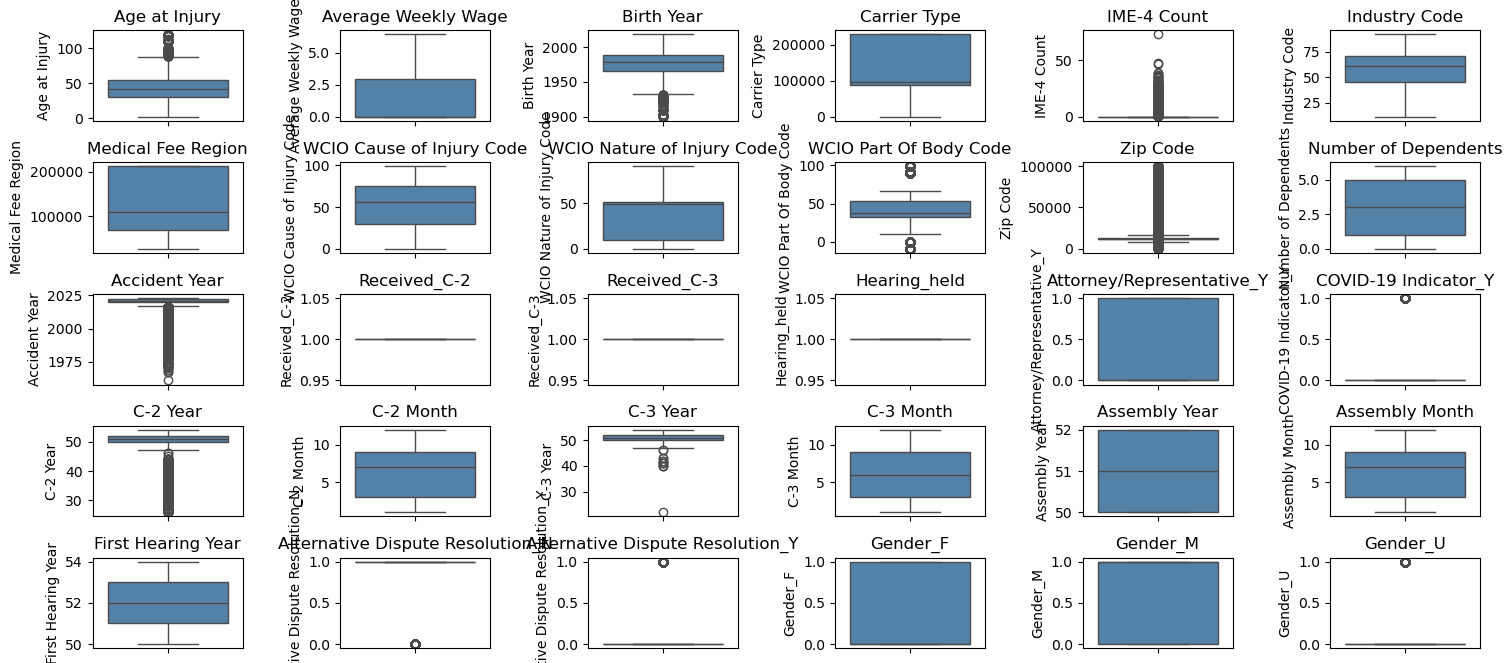

In [86]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 8))  

numeric_columns = train_set.select_dtypes(include=[np.number]).columns

# Create a grid of subplots for numeric columns
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(6, 6, i)  
    sns.boxplot(data=train_set[column], color='steelblue')
    plt.title(column)  

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Given the presence of outliers in some features, we will apply capping to mitigate their influence. This will be achieved by scaling the `train_set` using the Robust Scaler, which is less sensitive to outliers and ensures that the scaling is based on the interquartile range (IQR) rather than the mean and standard deviation.

<br>

#### 4.4 Feature Scaling

Before applying the scaler is necessary to first split the `train_set`, `val_set` and `test` into a numerical and categorical set. In this way, we can apply the scaler in the numerical features.

In [87]:
train_numerical = train_set.select_dtypes(include='number')
train_numerical = train_set.select_dtypes(include='number')
train_categorical = train_set.select_dtypes(include='object')

In [88]:
cat_cols = list(train_set.select_dtypes(include='object').columns)
num_cols = list(train_set.select_dtypes(include='number').columns)
#remove for x all the itemn in dummy_cols
for col in dummy_cols:
    num_cols.remove(col)
    
cat_cols.extend(dummy_cols)


In [89]:
train_numerical = train_set[num_cols]
train_categorical = train_set[cat_cols]

val_numerical = val_set[num_cols]
val_categorical = val_set[cat_cols]

test_numerical = test[num_cols]
test_categorical = test[cat_cols]

In [90]:
train_numerical.columns

Index(['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Carrier Type',
       'IME-4 Count', 'Industry Code', 'Medical Fee Region',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents',
       'Accident Year', 'Attorney/Representative_Y', 'C-2 Year', 'C-2 Month',
       'C-3 Year', 'C-3 Month', 'Assembly Year', 'Assembly Month',
       'First Hearing Year'],
      dtype='object')

In [91]:
train_categorical.columns

Index(['Carrier Name', 'County of Injury', 'District Name', 'Received_C-2',
       'Received_C-3', 'Hearing_held', 'Alternative Dispute Resolution_N',
       'Alternative Dispute Resolution_Y', 'Gender_F', 'Gender_M', 'Gender_U',
       'COVID-19 Indicator_Y'],
      dtype='object')

Scaler

In [92]:
scaler = RobustScaler().fit(train_numerical)

Fitting the scaler on the numerical training data and transforming the training data. Also, converts it to a dataframe.

In [93]:
X_train_rb = scaler.transform(train_numerical) 
X_train_rb = pd.DataFrame(X_train_rb, columns = train_numerical.columns).set_index(train_numerical.index)

Transforming the validation data using the same scaler and converting to a dataframe.

In [94]:
X_val_rb = scaler.transform(val_numerical) 
X_val_rb = pd.DataFrame(X_val_rb, columns = val_numerical.columns).set_index(val_numerical.index)

Transforming the test data using the same scaler and converting to a dataframe.

In [95]:
test_rb = scaler.transform(test_numerical) 
test_rb = pd.DataFrame(test_rb, columns = test_numerical.columns).set_index(test_numerical.index)


<br>

##### 4.5 Filling the missing values

Some features still contain missing values, we will impute them using the KNNImputer.

In [96]:
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


In [97]:
X_result = 0
max_score = 0
knn_inputer = 0
best_k = 0
_2nd_X_result = 0
_2nd_max_score = 0
_2nd_knn_inputer = 0
_2nd_best_k = 0

scores = []

for k in range(3, 8):
    print(f"======== Processing k = {k}========")
    imputer = KNNImputer(n_neighbors=k).fit(X_train_rb)
    train_imputed = imputer.transform(X_train_rb)
    val_imputed = imputer.transform(X_val_rb)
    model = RandomForestClassifier(n_estimators=5)
    model.fit(train_imputed, y_train_encoded)
    val_preds = model.predict(val_imputed)
    score = f1_score(y_test_encoded, val_preds, average='macro')
    
    if score > max_score:
        _2nd_X_result = X_result
        _2nd_max_score = max_score
        _2nd_knn_inputer = knn_inputer
        _2nd_best_k = best_k
        X_result = train_imputed
        max_score = score
        knn_inputer = imputer
        best_k = k
        scores.append(score)
    
    print(f"k={k}, F1-score={score}")


======== Processing k = 3========


KeyboardInterrupt: 

In [ ]:


for k in range(8, 11):
    print(f"======== Processing k = {k}========")
    imputer = KNNImputer(n_neighbors=k).fit(X_train_rb)
    train_imputed = imputer.transform(X_train_rb)
    val_imputed = imputer.transform(X_val_rb)
    model = RandomForestClassifier(n_estimators=5)
    model.fit(train_imputed, y_train_encoded)
    val_preds = model.predict(val_imputed)
    score = f1_score(y_test_encoded, val_preds, average='macro')
    
    if score > max_score:
        _2nd_X_result = X_result
        _2nd_max_score = max_score
        _2nd_knn_inputer = knn_inputer
        _2nd_best_k = best_k
        X_result = train_imputed
        max_score = score
        knn_inputer = imputer
        best_k = k
    scores.append(score)
    
    print(f"k={k}, F1-score={score}")


======== Processing k = 8========


KeyboardInterrupt: 

Given that the maximum f1 score is ..., we will impute the missing values using k equal to ... 

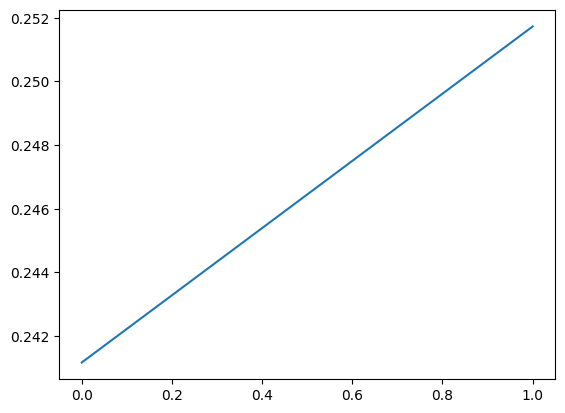

In [ ]:
plt.plot(scores,np.arange(3, 11))

In [ ]:
#knn_inputer = KNNImputer(n_neighbors=k).fit(X_train_rb)


Apply the fitted imputer to the training, validation, and test datasets.

In [ ]:
test_numerical_imputed = knn_inputer.transform(test_numerical)
test_numerical_imputed = pd.DataFrame(test_numerical_imputed, columns=test_numerical.columns, index=test_numerical.index)
test_numerical_imputed.to_csv('test_numerical_imputed.csv')

KeyboardInterrupt: 

In [ ]:
X_train_rb_imputed = knn_inputer.transform(X_train_rb)

In [ ]:
X_val_rb_imputed = knn_inputer.transform(X_val_rb)

Converting the imputed results back to DataFrames.

In [ ]:
X_train_rb_imputed = pd.DataFrame(X_train_rb_imputed, columns=X_train_rb.columns, index=X_train_rb.index)

In [ ]:
X_val_rb_imputed = pd.DataFrame(X_val_rb_imputed, columns=X_val_rb.columns, index=X_val_rb.index)

In [ ]:
test_numerical_imputed = pd.DataFrame(test_numerical_imputed, columns=test_numerical.columns, index=test_numerical.index)

In [ ]:
X_train_rb_imputed.to_csv("X_train_rb_imputed")

In [ ]:
X_val_rb_imputed.to_csv("X_val_rb_imputed")